# Computer Vision 2023 Assignment 2: Image matching and retrieval

In this prac, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the prac:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'

This will also remove the preamble text from each question. It has been packaged into a small notebook you can run in colab, called notebooktopdf.ipynb


We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

As with the last assignment it is somewhat up to you how you answer each question. Ensure that the outputs and report are clear and easy to read so that the markers can rapidly assess what you have done, why, and how deep is your understanding. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. You should copy these data into a directory A2_smvs, keeping the directory structure the same as in the zip file.  

Within each category (within each folder), there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [68]:
# Commenting out as I'm running locally

# from google.colab import drive
# drive.mount('/content/drive')

In [69]:
# !pwd
# %cd drive/MyDrive/Colab\ Notebooks
# !pwd

In [107]:
# Numpy is the main package for scientific computing with Python.
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor

# Matplotlib is a useful plotting library for python
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def draw_outline(ref, query, model, header=None):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h,w = ref.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,model)

    img = query.copy()
    img = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    if header:
        plt.title(header)
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()

def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask, header=None):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography()
    """
    matchesMask = matchesMask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)

    if header:
        plt.title(header)
    plt.imshow(img3, 'gray')
    plt.axis('off')
    plt.show()


# Question 1: Matching an object in a pair of images (60%)


In this question, the aim is to accurately locate a reference object in a query image, for example:

![Books](book.png "Books")

0. Download and read through the paper [ORB: an efficient alternative to SIFT or SURF](https://www.researchgate.net/publication/221111151_ORB_an_efficient_alternative_to_SIFT_or_SURF) by Rublee et al. You don't need to understand all the details, but try to get an idea of how it works. ORB combines the FAST corner detector (covered in week 3) and the BRIEF descriptor. BRIEF is based on similar ideas to the SIFT descriptor we covered week 3, but with some changes for efficiency.

1. [Load images] Load the first (reference, query) image pair from the "book_covers" category using opencv (e.g. `img=cv2.imread()`). Check the parameter option in "
cv2.imread()" to ensure that you read the gray scale image, since it is necessary for computing ORB features.

2. [Detect features] Create opencv ORB feature extractor by `orb=cv2.ORB_create()`. Then you can detect keypoints by `kp = orb.detect(img,None)`, and compute descriptors by `kp, des = orb.compute(img, kp)`. You need to do this for each image, and then you can use `cv2.drawKeypoints()` for visualization.

3. [Match features] As ORB is a binary feature, you need to use HAMMING distance for matching, e.g., `bf = cv2.BFMatcher(cv2.NORM_HAMMING)`. Then you are requried to do KNN matching (k=2) by using `bf.knnMatch()`. After that, you are required to use "ratio_test" to find good matches. By default, you can set `ratio=0.8`.

4. [Plot and analyze] You need to visualize the matches by using the `cv2.drawMatches()` function. Also you can change the ratio values, parameters in `cv2.ORB_create()`, and distance functions in `cv2.BFMatcher()`. Please discuss how these changes influence the match numbers.


In [72]:
# load images as grey scale
img1 = cv2.imread('a2/A2_smvs/book_covers/Reference/001.jpg', 0)
if not np.shape(img1):
  # Error message and print current working dir
  print("Could not load img1. Check the path, filename and current working directory\n")
  !pwd
img2 = cv2.imread("a2/A2_smvs/book_covers/Query/001.jpg", 0)
if not np.shape(img2):
  # Error message and print current working dir
  print("Could not load img2. Check the path, filename and current working directory\n")
  !pwd

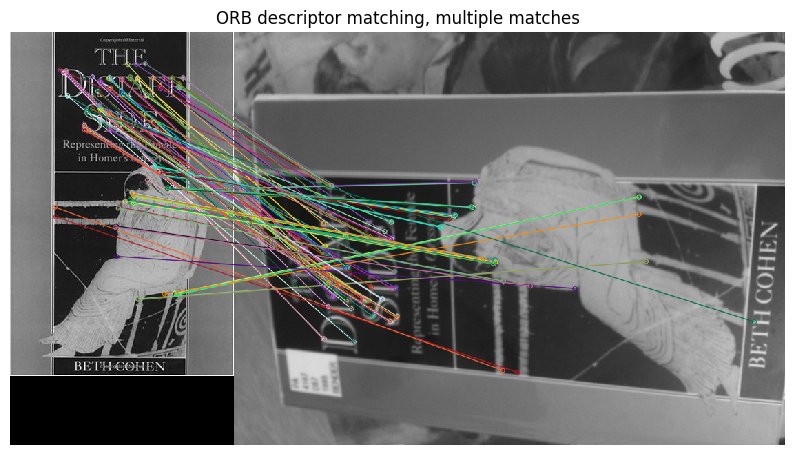

In [73]:
# Your code for descriptor matching tests here

def descriptor_matching(img1, img2):
    # compute detector and descriptor, see (2) above
    orb = cv2.ORB_create()
    kp1 = orb.detect(img1, None)
    kp2 = orb.detect(img2, None)

    # find the keypoints and descriptors with ORB, see (2) above
    kp1, des1 = orb.compute(img1, kp1)
    kp2, des2 = orb.compute(img2, kp2)

    # draw keypoints, see (2) above
    img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
    img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)

    # create BFMatcher object, see (3) above
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # Match descriptors, see (3) above
    matches = bf.knnMatch(des1, des2, k=2)
    return kp1, kp2, matches, img1_kp, img2_kp

kp1, kp2, matches, img1_kp, img2_kp = descriptor_matching(img1, img2)

# Apply ratio test, see (3) above
#good = []
#for m,n in matches:
good_matches = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good_matches.append([m])

# draw matches, see (4) above
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.title("ORB descriptor matching, multiple matches")
plt.axis('off')
plt.show()




***Your explanation of what you have done, and your results, here***

Firstly, creating and finding all the descriptors in the image using `cv2.ORB_create()` and `orb.detectAndCompute()`. Then following that the descriptiors are matched between the two images. Then using `cv2.drawMatches()` function to visualize the matches. From that matches that are found, keep anything that is over 80% and call these good matches. Using those matches draw the lines between the two images to show the matches this can be seen in the image above.

From the matches that where made we are able to conclude that we where able to match the two images, as there are a large quantiy of good matches between the two images. From this the refference image is able to be found in the query image. It can also be seen that the matches are not perfect as there are some matches that are not correct. This is due to that both images are not the same. It can also be seen that most of the matches are found between the titles of the two images, this would be becasue there is a lot more definition in the edges of the title.

3. Estimate a homography transformation based on the matches, using `cv2.findHomography()`. Display the transformed outline of the first reference book cover image on the query image, to see how well they match.

    - We provide a function `draw_outline()` to help with the display, but you may need to edit it for your needs.
    - Try the 'least squre method' option to compute homography, and visualize the inliers by using `cv2.drawMatches()`. Explain your results.
    - Again, you don't need to compare results numerically at this stage. Comment on what you observe visually.

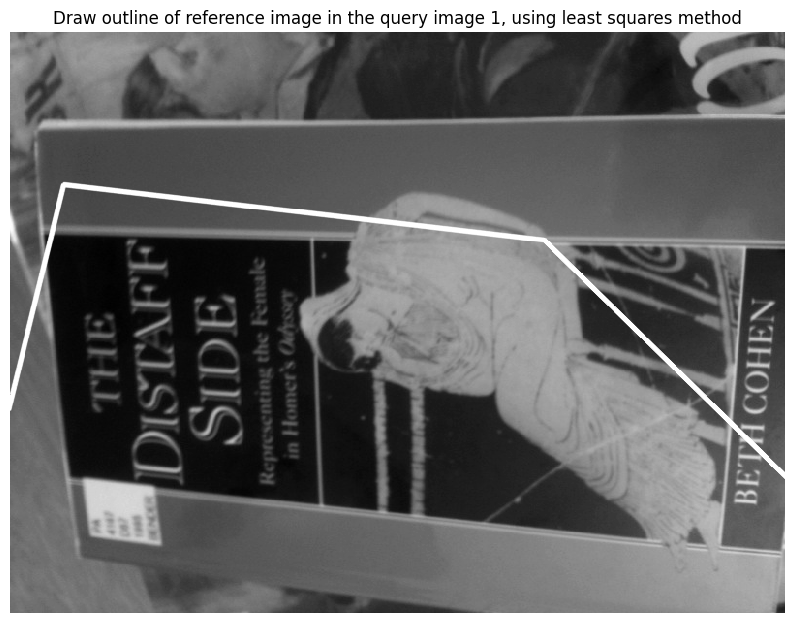

In [74]:
def find_homography(kp1, kp2, matches):
    """
        Find homography between images
        kp1 / kp2: keypoints from reference/query img
        good_matches : list of (good) matches after ratio test
    """
    # Create src_pts and dst_pts as float arrays to be passed into cv2.,findHomography
    # implementation from https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        print("There was not enough good matches - %d/%d" % (len(good_matches), 4))
        return None, None, None

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    # using cv2 standard method, see (3) above
    # without puttinig anything else into the following function it will use the least squares method
    model, mask = cv2.findHomography(src_pts, dst_pts)

    return model, mask, good_matches

model, mask, good_matches = find_homography(kp1, kp2, matches)

if model is not None:
    # draw frame
    draw_outline(img1, img2, model, "Draw outline of reference image in the query image 1, using least squares method")



***Your explanation of results here***

The above image is an example of the homography using the least squares method. As can been seen in the image above. the outlout that is genearted is around around the features that was picket up in the image the feature matching (this can be seen in the previous part). Though, this is not selecting the extire book it is alest deteching a large potion of the book.

Try the RANSAC option to compute homography. Change the RANSAC parameters, and explain your results. Print and analyze the inlier numbers.

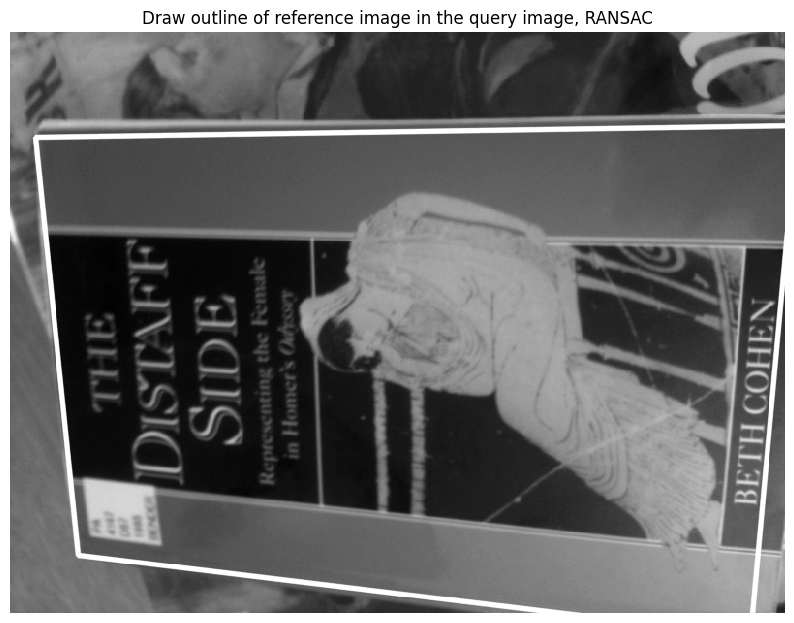

Number of inliers:  111


In [75]:
def find_homography_RANSAC(kp1, kp2, matches, print_fail=True):
    """
        Find homography between images
        kp1 / kp2: keypoints from reference/query img
        good_matches : list of (good) matches after ratio test
    """
    # Create src_pts and dst_pts as float arrays to be passed into cv2.,findHomography
    # implementation from https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        if print_fail:
            print("There was not enough good matches - %d/%d" % (len(good_matches), 4))
        return None, None, None

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    # Your code to display book location after RANSAC here

    # using RANSAC
    # using cv2 standard method, see (3) above
    model, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return model, mask, good_matches

model, mask, good_matches = find_homography_RANSAC(kp1, kp2, matches)


if model is not None:
    # draw frame
    draw_outline(img1, img2, model, "Draw outline of reference image in the query image, RANSAC")

    # inlier number
    inliers = np.sum(mask)
    print("Number of inliers: ", inliers)

***Your explanation of what you have tried, and results here***

6. Finally, try matching several different image pairs from the data provided, including at least one success and one failure case. For the failure case, test and explain what step in the feature matching has failed, and try to improve it. Display and discuss your findings.
    1. Hint 1: In general, the book covers should be the easiest to match, while the landmarks are the hardest.
    2. Hint 2: Explain why you chose each example shown, and what parameter settings were used.
    3. Hint 3: Possible failure points include the feature detector, the feature descriptor, the matching strategy, or a combination of these.

Processing image 50


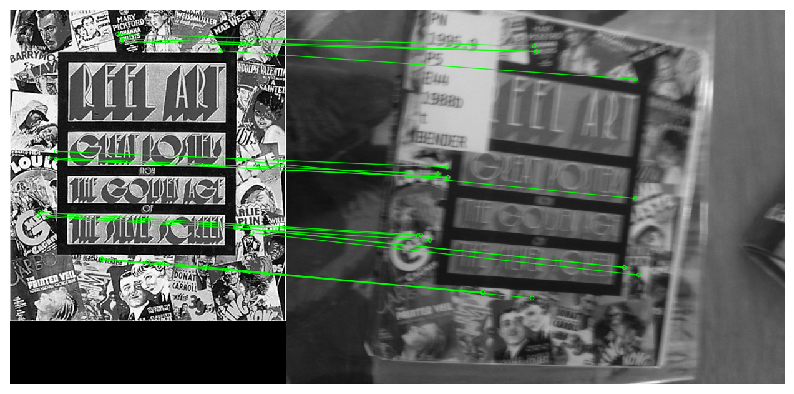

Processing Landscape image 2


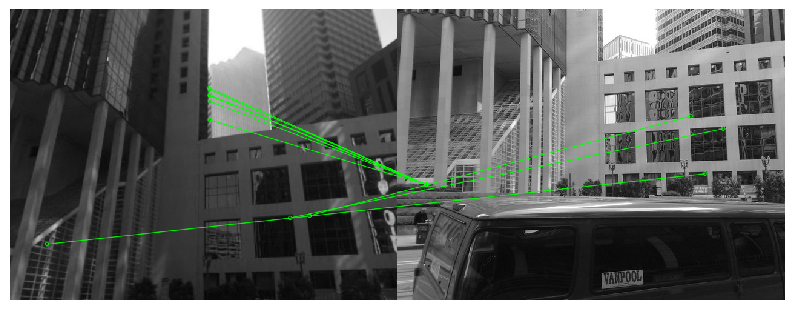

Processing Museum Painting image 2


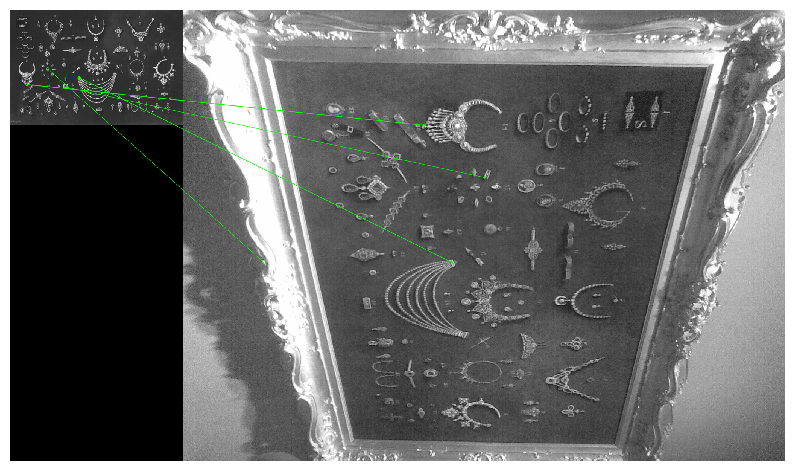

In [76]:
# Your results for other image pairs here
def book_cover_image(i):
    print(f"Processing image {i}")
    # load images as grey scale
    img1 = cv2.imread(f'a2/A2_smvs/book_covers/Reference/{str(i).zfill(3)}.jpg', 0)
    img2 = cv2.imread(f'a2/A2_smvs/book_covers/Query/{str(i).zfill(3)}.jpg', 0)

    kp1, kp2, matches, img1_kp, img2_kp = descriptor_matching(img1, img2)
    model, mask, good_matches = find_homography_RANSAC(kp1, kp2, matches)

    if model is not None:
        # draw inliers
        draw_inliers(img1, img2, kp1, kp2, good_matches, mask)

def landscape_image(i):
    print(f"Processing Landscape image {i}")
    # load images as grey scale
    img1 = cv2.imread(f'a2/A2_smvs/landmarks/Reference/{str(i).zfill(3)}.jpg', 0)
    img2 = cv2.imread(f'a2/A2_smvs/landmarks/Query/{str(i).zfill(3)}.jpg', 0)

    kp1, kp2, matches, img1_kp, img2_kp = descriptor_matching(img1, img2)
    model, mask, good_matches = find_homography_RANSAC(kp1, kp2, matches)

    if model is not None:
        # draw inliers
        draw_inliers(img1, img2, kp1, kp2, good_matches, mask)

def museum_painting_image(i):
    print(f"Processing Museum Painting image {i}")
    # load images as grey scale
    img1 = cv2.imread(f'a2/A2_smvs/museum_paintings/Reference/{str(i).zfill(3)}.jpg', 0)
    img2 = cv2.imread(f'a2/A2_smvs/museum_paintings/Query/{str(i).zfill(3)}.jpg', 0)

    kp1, kp2, matches, img1_kp, img2_kp = descriptor_matching(img1, img2)
    model, mask, good_matches = find_homography_RANSAC(kp1, kp2, matches)

    if model is not None:
        # draw inliers
        draw_inliers(img1, img2, kp1, kp2, good_matches, mask)

book_cover_image(50)
landscape_image(2)
museum_painting_image(2)


***Your explanation of results here***

# Question 2: What am I looking at? (40%)


<!--One application of feature matching is image retrieval. The goal of image retrieval is, given a query image of an object, to find all images in a database containing the same object, and return the results in ranked order (like a Google search). This is a huge research area but we will implement a very basic version of the problem based on the small dataset provided.-->

In this question, the aim is to identify an "unknown" object depicted in a query image, by matching it to multiple reference images, and selecting the highest scoring match. Since we only have one reference image per object, there is at most one correct answer. This is useful for example if you want to automatically identify a book from a picture of its cover, or a painting or a geographic location from an unlabelled photograph of it.

The steps are as follows:

1. Select a set of reference images and their corresponding query images. 

    1. Hint 1: Start with the book covers, or just a subset of them.
    3. Hing 2: This question can require a lot of computation to run from start to finish, so cache intermediate results (e.g. feature descriptors) where you can.
    
2. Choose one query image corresponding to one of your reference images. Use RANSAC to match your query image to each reference image, and count the number of inlier matches found in each case. This will be the matching score for that image.

3. Identify the query object. This is the identity of the reference image with the highest match score, or "not in dataset" if the maximum score is below a threshold.

4. Repeat steps 2-3 for every query image and report the overall accuracy of your method (that is, the percentage of query images that were correctly matched in the dataset). Discussion of results should include both overall accuracy and individual failure cases.

    1. Hint 1: In case of failure, what ranking did the actual match receive? If we used a "top-k" accuracy measure, where a match is considered correct if it appears in the top k match scores, would that change the result?

<!--Code to implement this algorithm should mostly be written in a supporting file such as a2code.py. Call your code and display outputs in the notebook below.--> 


In [124]:
# Your code to iddntify query objects and measure search accuracy for data set here

# First I want to load all the image in to arrays to be able to iterate over them later.
reference_images = []
query_images = []

for i in range(1, 100):
    img1 = cv2.imread(f'a2/A2_smvs/book_covers/Reference/{str(i).zfill(3)}.jpg', 0)
    img2 = cv2.imread(f'a2/A2_smvs/book_covers/Query/{str(i).zfill(3)}.jpg', 0)

    reference_images.append(img1)
    query_images.append(img2)

In [125]:
orb = cv2.ORB_create(nfeatures=1000)

def descriptor_matching(img1):
    # compute detector and descriptor, see (2) above
    kp1 = orb.detect(img1, None)

    # find the keypoints and descriptors with ORB, see (2) above
    kp1, des1 = orb.compute(img1, kp1)

    # draw keypoints, see (2) above
    img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
    return kp1, des1, img1_kp

def match(des1, des2):
    # create BFMatcher object, see (3) above
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # Match descriptors, see (3) above
    matches = bf.knnMatch(des1, des2, k=2)
    return matches

In [126]:
descriptor_query_images = []
for queryImage in query_images:
    kp1, des1, img1_kp = descriptor_matching(queryImage)
    descriptor_query_images.append((kp1, des1, img1_kp))

descriptor_reference_images = []
for referenceImage in reference_images:
    kp1, des1, img1_kp = descriptor_matching(referenceImage)
    descriptor_reference_images.append((kp1, des1, img1_kp))

In [127]:
correctGuesses = 0
k = 3
topK_correct = 0

def process_query(q):
    topMatches = []
    for r in range(len(reference_images)):
        kp1, des1, img1_kp = descriptor_reference_images[r]
        kp2, des2, img2_kp = descriptor_query_images[q]
        matches = match(des1, des2)
        model, mask, good_matches = find_homography_RANSAC(kp1, kp2, matches, False)

        if mask is not None:
            topMatches.append(np.sum(mask))
        else:
            topMatches.append(0)

    sorted_indices = np.argsort(-np.array(topMatches))  # Sort indices by descending match score
    return sorted_indices, topMatches

# Use ThreadPoolExecutor to parallelize processing
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_query, range(len(query_images))))

for q, (sorted_indices, topMatches) in enumerate(results):
    if max(topMatches) > 9:
        if q == sorted_indices[0]:
            correctGuesses += 1  # Exact match (top-1 accuracy)
        if q in sorted_indices[:k]:
            topK_correct += 1  # Top-k accuracy

accuracy = correctGuesses / len(query_images)
topK_accuracy = topK_correct / len(query_images)

print("Accuracy:", accuracy)
print(f"Top-{k} Accuracy:", topK_accuracy)

Accuracy: 0.5555555555555556
Top-3 Accuracy: 0.7777777777777778


***Your explanation of what you have done, and your results, here***

One way that I would be able to increate the accuracy of the image is being able to calcul

5. Choose some extra query images of objects that do not occur in the reference dataset. Repeat step 4 with these images added to your query set. Accuracy is now measured by the percentage of query images correctly identified in the dataset, or correctly identified as not occurring in the dataset. Report how accuracy is altered by including these queries, and any changes you have made to improve performance.

In [108]:
# adding the extra query images
for i in range(1, 30):
    img2 = cv2.imread(f'a2/A2_smvs/landmarks/Query/{str(i).zfill(3)}.jpg', 0)

    query_images.append(img2)

In [110]:
descriptor_query_images = []
for queryImage in query_images:
    kp1, des1, img1_kp = descriptor_matching(queryImage)
    descriptor_query_images.append((kp1, des1, img1_kp))

descriptor_reference_images = []
for referenceImage in reference_images:
    kp1, des1, img1_kp = descriptor_matching(referenceImage)
    descriptor_reference_images.append((kp1, des1, img1_kp))

In [111]:
correctGuesses = 0
k = 3
topK_correct = 0

def process_query(q):
    topMatches = []
    for r in range(len(reference_images)):
        kp1, des1, img1_kp = descriptor_reference_images[r]
        kp2, des2, img2_kp = descriptor_query_images[q]
        matches = match(des1, des2)
        model, mask, good_matches = find_homography_RANSAC(kp1, kp2, matches, False)

        if mask is not None:
            topMatches.append(np.sum(mask))
        else:
            topMatches.append(0)

    sorted_indices = np.argsort(-np.array(topMatches))  # Sort indices by descending match score
    return sorted_indices, topMatches

# Use ThreadPoolExecutor to parallelize processing
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_query, range(len(query_images))))

for q, (sorted_indices, topMatches) in enumerate(results):
    if max(topMatches) > 50:
        if q == sorted_indices[0]:
            correctGuesses += 1  # Exact match (top-1 accuracy)
        if q in sorted_indices[:k]:
            topK_correct += 1  # Top-k accuracy

accuracy = correctGuesses / len(query_images)
topK_accuracy = topK_correct / len(query_images)

print("Accuracy:", accuracy)
print(f"Top-{k} Accuracy:", topK_accuracy)

Accuracy: 0.25
Top-3 Accuracy: 0.3359375


***Your explanation of results and any changes made here***


6. Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


In [117]:
# Your code to search images and display results here
reference_images = []
query_images = []

for i in range(1, 100):
    img1 = cv2.imread(f'a2/A2_smvs/book_covers/Reference/{str(i).zfill(3)}.jpg', 0)
    img2 = cv2.imread(f'a2/A2_smvs/book_covers/Query/{str(i).zfill(3)}.jpg', 0)

    reference_images.append(img1)
    query_images.append(img2)

for i in range(1, 100):
    img1 = cv2.imread(f'a2/A2_smvs/landmarks/Reference/{str(i).zfill(3)}.jpg', 0)
    img2 = cv2.imread(f'a2/A2_smvs/landmarks/Query/{str(i).zfill(3)}.jpg', 0)

    reference_images.append(img1)
    query_images.append(img2)

for i in range(1, 91):
    img1 = cv2.imread(f'a2/A2_smvs/museum_paintings/Reference/{str(i).zfill(3)}.jpg', 0)
    img2 = cv2.imread(f'a2/A2_smvs/museum_paintings/Query/{str(i).zfill(3)}.jpg', 0)

    reference_images.append(img1)
    query_images.append(img2)

In [121]:
orb = cv2.ORB_create(nfeatures=1000)

def descriptor_matching(img1):
    # compute detector and descriptor, see (2) above
    kp1 = orb.detect(img1, None)

    # find the keypoints and descriptors with ORB, see (2) above
    kp1, des1 = orb.compute(img1, kp1)

    # draw keypoints, see (2) above
    img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
    return kp1, des1, img1_kp

def match(des1, des2):
    # create BFMatcher object, see (3) above
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # Match descriptors, see (3) above
    matches = bf.knnMatch(des1, des2, k=2)
    return matches

In [122]:
descriptor_query_images = []
for queryImage in query_images:
    kp1, des1, img1_kp = descriptor_matching(queryImage)
    descriptor_query_images.append((kp1, des1, img1_kp))

descriptor_reference_images = []
for referenceImage in reference_images:
    kp1, des1, img1_kp = descriptor_matching(referenceImage)
    descriptor_reference_images.append((kp1, des1, img1_kp))

In [123]:
correctGuesses = 0
k = 3
topK_correct = 0

def process_query(q):
    topMatches = []
    for r in range(len(reference_images)):
        kp1, des1, img1_kp = descriptor_reference_images[r]
        kp2, des2, img2_kp = descriptor_query_images[q]
        matches = match(des1, des2)
        model, mask, good_matches = find_homography_RANSAC(kp1, kp2, matches, False)

        if mask is not None:
            topMatches.append(np.sum(mask))
        else:
            topMatches.append(0)

    sorted_indices = np.argsort(-np.array(topMatches))  # Sort indices by descending match score
    return sorted_indices, topMatches

# Use ThreadPoolExecutor to parallelize processing
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_query, range(len(query_images))))

for q, (sorted_indices, topMatches) in enumerate(results):
    if max(topMatches) > 50:
        if q == sorted_indices[0]:
            correctGuesses += 1  # Exact match (top-1 accuracy)
        if q in sorted_indices[:k]:
            topK_correct += 1  # Top-k accuracy

accuracy = correctGuesses / len(query_images)
topK_accuracy = topK_correct / len(query_images)

print("Accuracy:", accuracy)
print(f"Top-{k} Accuracy:", topK_accuracy)

Accuracy: 0.2604166666666667
Top-3 Accuracy: 0.2604166666666667


***Your description of what you have done, and explanation of results, here***